# Field delineation

 <div class="alert alert-block alert-info"><b>This notebooks includes the training and  prediction using  a neural network. 
    If running over a smaller area a CPU-only machine can be used, however if running on larger areas, we recommend using a machine with a GPU setup to speed up the processing time for those steps.  </b> 

To run this  notebook out of the box, access to an Amazon AWS S3 bucket is required. Furthermore, the download of the satellite imagery is done through [Sentinel Hub](https://www.sentinel-hub.com/). To run locally (or with existing data) some modifications of the code might be required. 

The following data is a prerequisite for running this notebook:
  - **The georeferenced file with the area of interest** 
  - **Field boundary ground-truth data is required for training** 

In [94]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import logging

import os
import json
import argparse
import sys
import shutil
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path, PosixPath

from eolearn.core import EOPatch, EOExecutor 
from sentinelhub import SHConfig
from shapely.geometry import Polygon

from fs.copy import copy_file


from fd.scripts.tiffs_to_eopatches import convert_tiff_to_eopatches
from fd.scripts.tiffs_to_gpkg import generate_grid_from_tiff, save_grid_as_gpkg
from fd.scripts.tiffs_to_geojson import extract_polygons_from_tiff, save_polygons_as_geojson
# from fd.scripts.sampling import sample_patchlets
# from fd.scripts.patchlets_to_npz import patchlets_to_npz_files
# from fd.scripts.normalization import calculate_normalization_factors
# from fd.scripts.k_folds_split import k_fold_split
# from fd.scripts.train import train_k_folds
# from fd.scripts.predict import run_prediction
# from fd.scripts.postprocessing import run_post_processing
# from fd.scripts.vectorization import vectorise
# from fd.scripts.utm_zone_merging import merge_zones

#from nc_to_eopatch import create_eopatch_from_nc

from scirpts.eopatches_for_sampling import create_eopatch_from_nc_and_tiff
from scirpts.creation_patchlets import SamplePatchlets, FeatureType
from scirpts.patchlets_to_npz import patchlets_to_npz_files
from scirpts.normalization import calculate_normalization_factors
from scirpts.test2_kfold import k_folds

from fd.utils import BaseConfig, prepare_filesystem
#from fd.utils_plot import (draw_vector_timeless, draw_true_color, draw_bbox, draw_mask, get_extent)
logging.getLogger().setLevel(logging.ERROR)

# Setup credentials 

In [96]:
LOCAL_STORAGE_PATH = '/home/joseph/Code/localstorage'

SH_CLIENT_ID = '8506f8e1-c699-49e7-93d7-733eaee7536c' # id de mon compte sentinelhub 
SH_CLIENT_SECRET = 'KS4Tlyet1AAy9w8SbW59RPmNjL4xME53' # mdp de la session sentinelhub

In [97]:
base_config = BaseConfig(local_storage_path=LOCAL_STORAGE_PATH,
                         sh_client_id=SH_CLIENT_ID,
                         sh_client_secret=SH_CLIENT_SECRET)

filesystem = prepare_filesystem(base_config)

In [98]:
PROJECT_DATA_ROOT = '/home/joseph/Code/localstorage' # !! Local folder where project related  files are/will be stored !!  


TIME_INTERVAL = ['2024-05-07', '2024-06-08'] # Set the time interval for which the data will be downloaded  

BATCH_TIFFS_FOLDER = '/home/joseph/Code/localstorage/dataset/orthophoto/images/FR' # Location on the bucket where downloaded TIFF images will be stored

# Convert to EOPatches

**Define folder where EOPatches will be stored.** 

In [99]:
# Chemins vers les fichiers
nc_file_path = '/home/joseph/Code/localstorage/dataset/sentinel2/images/FR/FR_9334_S2_10m_256.nc'
vector_data_path = '/home/joseph/Code/localstorage/aoi_geometry.geojson'
mask_tiff_path = '/home/joseph/Code/localstorage/dataset/sentinel2/masks/FR/FR_9334_S2label_10m_256.tif'
EOPATCHES_FOLDER = '/home/joseph/Code/localstorage/eopatchs/'

# Créer l'EOPatch à partir des données NetCDF
create_eopatch_from_nc_and_tiff(nc_file_path, vector_data_path, mask_tiff_path, EOPATCHES_FOLDER)

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(6, 256, 256, 4), dtype=float32)
    NDVI: numpy.ndarray(shape=(6, 256, 256, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    BOUNDARY: numpy.ndarray(shape=(256, 256, 1), dtype=float32)
    DISTANCE: numpy.ndarray(shape=(256, 256, 1), dtype=float32)
    ENUM: numpy.ndarray(shape=(256, 256, 1), dtype=float32)
    EXTENT: numpy.ndarray(shape=(256, 256, 1), dtype=float32)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((3254213.5786972563, 2323561.0247092275), (3398725.708909825, 2944045.6000022995)), crs=CRS('3035'))
  timestamp: [datetime.datetime(2019, 3, 1, 0, 0, tzinfo=tzlocal()), ...], length=6
)

Check if EOPatches have been written

In [100]:
EOPATCHES_FOLDER_PATH = Path(EOPATCHES_FOLDER)
eops = [eop for eop in EOPATCHES_FOLDER_PATH.iterdir() if eop.is_dir()]

In [101]:
print(eops)

[PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240708_140755'), PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240708_132717'), PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240708_135619'), PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240708_132649'), PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240704_095825'), PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240704_121223'), PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240704_092728'), PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240702_134232'), PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240704_095515'), PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240708_114844'), PosixPath('/home/joseph/Code/localstorage/eopatchs/eopatch_20240708_132608')]


Load a sample EOPatch to check the values 

In [102]:
eops = [eop for eop in os.listdir(EOPATCHES_FOLDER) if os.path.isdir(os.path.join(EOPATCHES_FOLDER, eop))]

eop_path = os.path.join(EOPATCHES_FOLDER, eops[0])
eop = EOPatch.load(eop_path)

eop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(6, 256, 256, 4), dtype=float32)
    NDVI: numpy.ndarray(shape=(6, 256, 256, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    BOUNDARY: numpy.ndarray(shape=(256, 256, 1), dtype=float32)
    DISTANCE: numpy.ndarray(shape=(256, 256, 1), dtype=float32)
    ENUM: numpy.ndarray(shape=(256, 256, 1), dtype=float32)
    EXTENT: numpy.ndarray(shape=(256, 256, 1), dtype=float32)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((3254213.5786972563, 2323561.0247092275), (3398725.708909825, 2944045.6000022995)), crs=CRS('3035'))
  timestamp: [datetime.datetime(2019, 3, 1, 0, 0, tzinfo=tzlocal()), ...], length=6
)

Text(0.5, 1.0, 'RGB bands')

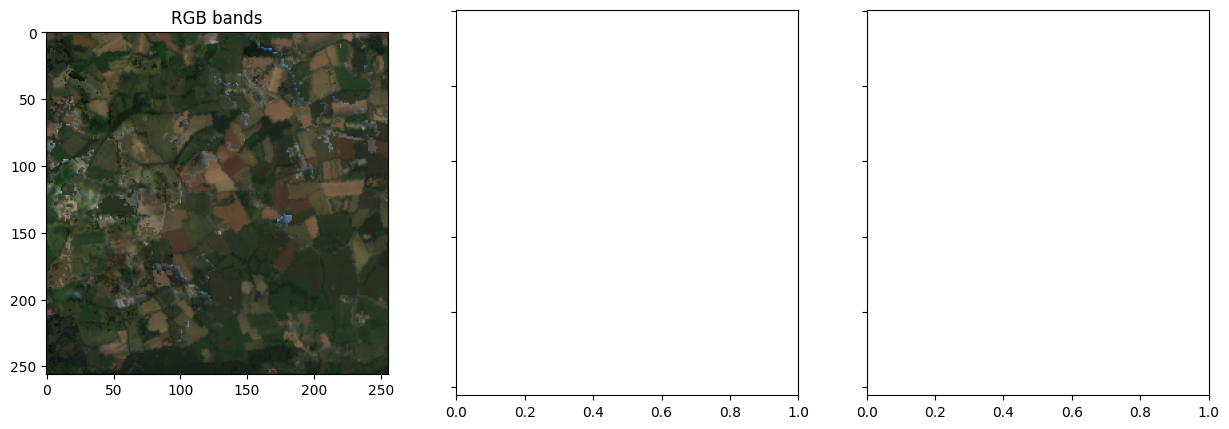

In [103]:
tidx = 3 # select one timestamp between 0 and number of timestamps in the EOPatch
viz_factor = 2.5

fig, axs = plt.subplots(figsize=(15, 5), ncols=3, sharey=True)
axs[0].imshow(viz_factor * eop.data['BANDS'][tidx][..., [2,1,0]]/10000)
axs[0].set_title('RGB bands')
# axs[1].imshow(eop.data['CLP'][tidx].squeeze()/255, vmin=0, vmax=1)
# axs[1].set_title('Cloud probability')
# axs[2].imshow(eop.mask['IS_DATA'][tidx].squeeze(), vmin=0, vmax=1)
# axs[2].set_title('Valid data')

# Sample Patchlets from EOPatches


This part samples image chips out of the larger `EOPatches`. A maximum number of chips is sampled randomly from the `EOPatch`, depending on the fraction of reference `EXTENT` pixels. A buffer where patchlets are not sampled from can also be specified. Image chips containing only valid image data and a cloud coverage lower than a threshold are sampled.


In [104]:
# Configuration for sampling patchlets
eopatch_path = '/home/joseph/Code/localstorage/eopatchs/eopatch_20240704_092728'
PATCHLETS_FOLDER = '/home/joseph/Code/localstorage/patchlets'
sample_positive = True
mask_feature_name = 'EXTENT'
buffer = 0
patch_size = 256
num_samples = 10
max_retries = 10
fraction_valid = 0.4
sampled_feature_name = 'BANDS'

eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

task = SamplePatchlets(
    feature=(FeatureType.MASK_TIMELESS, mask_feature_name),
    buffer=buffer,
    patch_size=patch_size,
    num_samples=num_samples,
    max_retries=max_retries,
    fraction_valid=fraction_valid,
    sample_features=[
        (FeatureType.DATA, sampled_feature_name),
        (FeatureType.MASK_TIMELESS, 'EXTENT'),
        (FeatureType.MASK_TIMELESS, 'BOUNDARY'),
        (FeatureType.MASK_TIMELESS, 'DISTANCE')
    ],
    sample_positive=sample_positive
)

patchlets = task.execute(eopatch)

for i, patchlet in enumerate(patchlets):
    patchlet_path = os.path.join(PATCHLETS_FOLDER, f'patchlet_{i}')
    if os.path.exists(patchlet_path):
        shutil.rmtree(patchlet_path)
    patchlet.save(patchlet_path)

In [105]:
patchlets = os.listdir(PATCHLETS_FOLDER)

In [106]:
patchlet_filename = os.path.join(PATCHLETS_FOLDER, patchlets[9])
patchlet = EOPatch.load(patchlet_filename)

In [107]:
patchlet.data['BANDS'].shape

(6, 256, 256, 4)

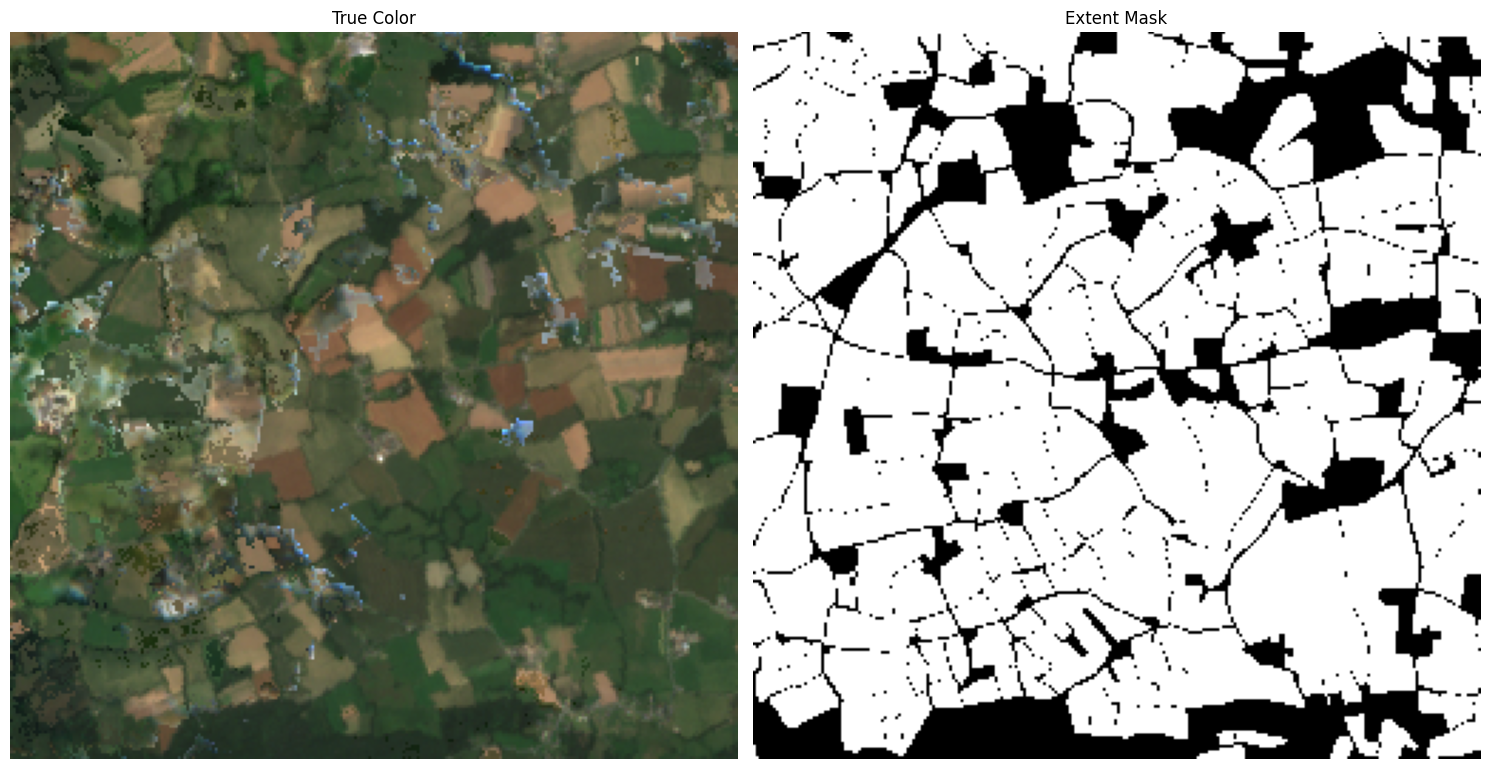

In [108]:
# Charger un patchlet spécifique
patchlet_path = os.path.join(PATCHLETS_FOLDER, 'patchlet_9')
patchlet = EOPatch.load(patchlet_path)

def draw_true_color(ax, eopatch, time_idx, factor, feature_name, bands, grid):
    image = eopatch.data[feature_name][time_idx]
    ax.imshow(image[:,:,bands] * factor)
    ax.set_title('True Color')
    if not grid:
        ax.grid(False)
    ax.axis('off')

# Fonction pour dessiner le masque d'étendue
def draw_extent_mask(ax, eopatch, feature_name, alpha, grid):
    mask = eopatch.mask_timeless[feature_name]
    ax.imshow(mask.squeeze(), cmap='gray', alpha=alpha)
    ax.set_title('Extent Mask')
    if not grid:
        ax.grid(False)
    ax.axis('off')

# Création de la figure avec deux sous-plots
fig, ax = plt.subplots(ncols=2, figsize=(15, 15))

# Affichage de l'image true color
draw_true_color(ax[0], patchlet, time_idx=3, factor=3.5/10000, feature_name='BANDS', bands=(2, 1, 0), grid=False)

# Affichage du masque d'étendue
draw_extent_mask(ax[1], patchlet, feature_name='EXTENT', alpha=1, grid=False)

# Affichage de la figure
plt.tight_layout()
plt.show()

# Create .npz files from patchlets

This steps creates a series of `.npz` files which join the data and labels sampled in patchlets from the previous iteration. A dataframe is created to keep track of the origin of the patchlets, namely which eopatch they come from and at which position they were sampled. This dataframe is later used for the cross-validation splits. 

In [109]:
NPZ_FILES_FOLDER = '/home/joseph/Code/localstorage/npz_files'  # Location on the bucket to which the NPZ files will be saved. 

#  Filepath to which the metadata dataframe will be saved. 
#  Needs to be a CSV file!  
METADATA_DATAFRAME = '/home/joseph/Code/localstorage/dataframe.csv' 

chunk_size = 1000

In [110]:
patchlets_to_npz_files(PATCHLETS_FOLDER, NPZ_FILES_FOLDER, chunk_size, METADATA_DATAFRAME)

Make some sanity checks on the created NPZ files

In [111]:
os.listdir(NPZ_FILES_FOLDER)

['patchlets_field_delineation_0.npz']

In [112]:
npzfile_path = os.path.join(NPZ_FILES_FOLDER, 'patchlets_field_delineation_0.npz')
with open(npzfile_path, 'rb') as f:
    npzfile = np.load(f)

In [113]:
list(npzfile.keys())

['X', 'y_boundary', 'y_extent', 'y_distance', 'timestamps', 'eopatches']

In [114]:
with open(METADATA_DATAFRAME, 'r') as f:
    df = pd.read_csv(f)
df.head()

,chunk,eopatch,patchlet,chunk_pos,timestamp
0,patchlets_field_delineation_0.npz,patchlet,/home/joseph/Code/localstorage/patchlets/patch...,0,2019-03-01 00:00:00+01:00
1,patchlets_field_delineation_0.npz,patchlet,/home/joseph/Code/localstorage/patchlets/patch...,1,2019-04-01 00:00:00+02:00
2,patchlets_field_delineation_0.npz,patchlet,/home/joseph/Code/localstorage/patchlets/patch...,2,2019-05-01 00:00:00+02:00
3,patchlets_field_delineation_0.npz,patchlet,/home/joseph/Code/localstorage/patchlets/patch...,3,2019-06-01 00:00:00+02:00
4,patchlets_field_delineation_0.npz,patchlet,/home/joseph/Code/localstorage/patchlets/patch...,4,2019-07-01 00:00:00+02:00


# Calculate normalization stats per timestamp 

This step computes the normalisation factors per band per month for the `.npz` files obtained so far. 
These normalisation factors are saved to `.csv` file and will be used at training and validation of the model.

In [115]:
calculate_normalization_factors(NPZ_FILES_FOLDER, METADATA_DATAFRAME)

Check that normalization factors were added to the metadata dataframe

In [116]:
# Mettre le dataframe en PosixPath
METADATA_DATAFRAME_PATH = PosixPath(METADATA_DATAFRAME)

# On affiche 10 colonnes sur les 38
pd.set_option('display.max_columns', 10)

# Ouvrir le fichier CSV en mode binaire et lire avec pandas
with open(METADATA_DATAFRAME_PATH, 'rb') as file:
    # Afficher les premières lignes du dataframe
    print(pd.read_csv(file).head())

                               chunk   eopatch  \
0  patchlets_field_delineation_0.npz  patchlet   
1  patchlets_field_delineation_0.npz  patchlet   
2  patchlets_field_delineation_0.npz  patchlet   
3  patchlets_field_delineation_0.npz  patchlet   
4  patchlets_field_delineation_0.npz  patchlet   

                                            patchlet  chunk_pos  \
0  /home/joseph/Code/localstorage/patchlets/patch...          0   
1  /home/joseph/Code/localstorage/patchlets/patch...          1   
2  /home/joseph/Code/localstorage/patchlets/patch...          2   
3  /home/joseph/Code/localstorage/patchlets/patch...          3   
4  /home/joseph/Code/localstorage/patchlets/patch...          4   

             timestamp  ...  norm_meanstd_median_b3  norm_meanstd_std_b0  \
0  2019-02-28 23:00:00  ...                  3500.0           183.515137   
1  2019-03-31 22:00:00  ...                  3630.0           230.523193   
2  2019-04-30 22:00:00  ...                  3924.0           289.05

# Split patchlets for k-fold cross-validation

This step:

 * loads the dataframe with the patchlets descriptions
 * splits the eopatches and corresponding patchlets into k-folds
 * updates the info csv file with fold information

In [117]:
N_FOLDS = 3  
SEED = 2  

k_folds(METADATA_DATAFRAME, N_FOLDS, SEED)

Some sanity checks: 

In [118]:
for fold in range(N_FOLDS):
    fold_path = os.listdir(os.path.join(NPZ_FILES_FOLDER, f'fold_{fold+1}'))
    print(f'In Fold {fold+1}:')
    print(fold_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/joseph/Code/localstorage/npz_files/fold_1'

# Train a ResUnetA model

This step  performs training of the `ResUnetA` architecture using the `.npz` files prepared in the previous steps:

This steps:

 * creates TensorFlow datasets in a k-fold cross-validation scheme, using the npz files previously created. The datasets allow manipulation and loading on the fly, to reduce RAM load and processing of large AOIs
 * performs training of the k-fold models  
 * test the models predictions on a validation batch
 

This workflow can load the `.npz` files from the S3 bucket, or locally. The training will be faster if files are copied and loaded from local disk. Change the `npz_from_s3` flag in the data loader function.

In [10]:
LOCAL_MODEL_FOLDER = os.path.join(PROJECT_DATA_ROOT, '') # Local path to the folder where models are saved 
S3_MODEL_FOLDER = '' #  Path to the bucket folder  models are saved 
CHKPT_FOLDER=None # Path to pretrained model if exists 

In [37]:
train_k_folds_config = {
    "bucket_name": BUCKET_NAME,  
    "aws_access_key_id": AWS_ACCESS_KEY_ID,
    "aws_secret_access_key": AWS_SECRET_ACCESS_KEY,
    "aws_region": AWS_REGION,
    "wandb_id": None, 
    "npz_folder": NPZ_FILES_FOLDER,
    "npz_from_s3": True,
    "num_parallel": 100,
    "metadata_path": METADATA_DATAFRAME, 
    "model_folder": LOCAL_MODEL_FOLDER,
    "model_s3_folder": S3_MODEL_FOLDER,
    "chkpt_folder": CHKPT_FOLDER,
    "input_shape": [256, 256, 4],
    "n_classes": 2,
    "batch_size": 8,
    "iterations_per_epoch": 1500,  # Change based on the size of the AOI
    "num_epochs": 30, 
    "model_name": "resunet-a",
    "reference_names": ["extent","boundary","distance"],
    "augmentations_feature": ["flip_left_right", "flip_up_down", "rotate", "brightness"],
    "augmentations_label": ["flip_left_right", "flip_up_down", "rotate"],
    "normalize": "to_medianstd",
    "n_folds": N_FOLDS,
    "fill_value": -2,
    "seed": 42,
    "wandb_project": "",
    "model_config": {
        "learning_rate": 0.0001,
        "n_layers": 3,
        "n_classes": 2,
        "keep_prob": 0.8,
        "features_root": 32,
        "conv_size": 3,
        "conv_stride": 1,
        "dilation_rate": [1, 3, 15, 31],
        "deconv_size": 2,
        "add_dropout": True,
        "add_batch_norm": False,
        "use_bias": False,
        "bias_init": 0.0,
        "padding": "SAME",
        "pool_size": 3,
        "pool_stride": 2,
        "prediction_visualization": True,
        "class_weights": None
    }
}


In [ ]:
train_k_folds(train_k_folds_config)

**A model is trained for each fold and then the weights of these models are averaged out to create 
a single model that is applied to the whole AOI.**

In [47]:
AVG_MODELS = [x for x in os.listdir(LOCAL_MODEL_FOLDER) if 'avg' in x] 
AVG_MODELS

['resunet-a_avg_2022-02-22-14-21-33']

In [49]:
AVG_MODEL = AVG_MODELS[0]

# Make prediction 

In [50]:
prediction_config = {
    "bucket_name": BUCKET_NAME, 
    "aws_access_key_id": AWS_ACCESS_KEY_ID,
    "aws_secret_access_key": AWS_SECRET_ACCESS_KEY,
    "aws_region": AWS_REGION,
    "grid_filename": GRID_PATH,
    "eopatches_folder": EOPATCHES_FOLDER,
    "feature_bands": ["data", "BANDS"],
    "feature_extent": ["data", "EXTENT_PREDICTED"],
    "feature_boundary": ["data", "BOUNDARY_PREDICTED"],
    "feature_distance": ["data", "DISTANCE_PREDICTED"],
    "model_path": S3_MODEL_FOLDER,
    "model_name": AVG_MODEL,
    "model_version": "v1",
    "temp_model_path": LOCAL_MODEL_FOLDER,
    "normalise": "to_meanstd",
    "height": 1128,
    "width": 1128,
    "pad_buffer": 14,
    "crop_buffer": 26,
    "n_channels": 4,
    "n_classes": 2,
    "metadata_path": METADATA_DATAFRAME,
    "batch_size": 1
}

In [51]:
logging.getLogger().setLevel(logging.INFO)

In [52]:
pred = run_prediction(prediction_config)

[2022-02-23 08:47:45,389] {predict.py:75} INFO - Load normalisation factors
[2022-02-23 08:47:45,568] {predict.py:78} INFO - Load grid definition
[2022-02-23 08:47:45,576] {predict.py:83} INFO - Load model
[2022-02-23 08:47:51,122] {predict.py:88} INFO - Running predictions


  0%|          | 0/6 [00:00<?, ?it/s]

2022-02-23 08:47:55.799105: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


[2022-02-23 08:50:24,929] {predict.py:96} INFO - Check status of prediction
[2022-02-23 08:50:24,932] {predict.py:98} INFO - 6 total eopatches, 0 failed
[2022-02-23 08:50:24,934] {predict.py:99} INFO - Failed EOPatches are Series([], Name: name, dtype: object)


In [ ]:
logging.getLogger().setLevel(logging.ERROR)

In [80]:
eop = EOPatch.load(os.path.join(EOPATCHES_FOLDER, eops[4]), filesystem=filesystem)

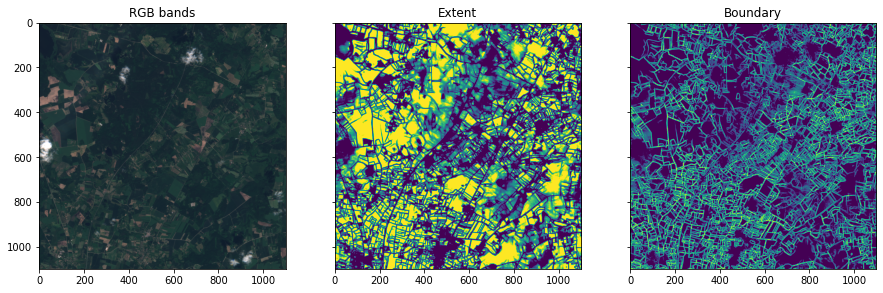

In [71]:
tidx = 12 # select one timestamp
viz_factor = 2.5

fig, axs = plt.subplots(figsize=(15, 5), ncols=3, sharey=True)
axs[0].imshow(viz_factor * eop.data['BANDS'][tidx][..., [2,1,0]]/10000)
axs[0].set_title('RGB bands')
axs[1].imshow(eop.data['EXTENT_PREDICTED'][tidx].squeeze(), vmin=0, vmax=1)
axs[1].set_title('Extent')
axs[2].imshow(eop.data['BOUNDARY_PREDICTED'][tidx].squeeze(), vmin=0, vmax=1)
axs[2].set_title('Boundary');

Text(0.5, 1.0, 'Boundary')

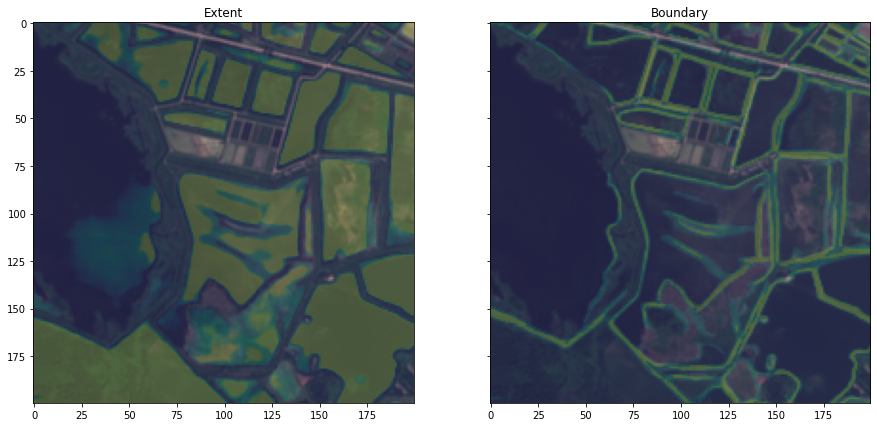

In [73]:
tidx = 12  # select one timestamp 
viz_factor = 3.5

fig, axs = plt.subplots(figsize=(15, 10), ncols=2, sharey=True)
axs[0].imshow(viz_factor * eop.data['BANDS'][tidx][:200, :200, [2,1,0]]/10000)
axs[0].set_title('RGB bands')
axs[0].imshow(eop.data['EXTENT_PREDICTED'][tidx].squeeze()[:200, :200], vmin=0, vmax=1, alpha=.2)
axs[0].set_title('Extent')
axs[1].imshow(viz_factor * eop.data['BANDS'][tidx][:200, :200, [2,1,0]]/10000)
axs[1].set_title('RGB bands')
axs[1].imshow(eop.data['BOUNDARY_PREDICTED'][tidx].squeeze()[:200, :200], vmin=0, vmax=1, alpha=.2)
axs[1].set_title('Boundary')

# Postprocessing 

Predictions for each timestamp within the requested period have been saved to the EOPatches. We need to temporally merge these predictions to get one prediction for each area.

The following steps are executed:
* merge predictions over a time interval using percentile statistics (median is used)
* join the extent and boundary predictions derived from previous step 
* iteratively smooth and upscale the joined prediction for a visually smoother output
* export the resulting map as .tif to be used for vectorisation

**Define folder where rasterized predictions will be saved to**

In [11]:
RASTER_RESULTS_FOLDER = '' # Location on the bucket to which the per-eopatch tiff files will be saved. 

In [78]:
postprocessing_config = {
    "bucket_name": BUCKET_NAME, 
    "aws_access_key_id": AWS_ACCESS_KEY_ID,
    "aws_secret_access_key": AWS_SECRET_ACCESS_KEY,
    "aws_region": AWS_REGION,
    "grid_filename": GRID_PATH,
    "time_intervals": {"MAY": ["2021-05-01", "2021-05-31"]}, 
    "eopatches_folder": EOPATCHES_FOLDER,
    "tiffs_folder": RASTER_RESULTS_FOLDER,
    "feature_extent": ["data", "EXTENT_PREDICTED"],
    "feature_boundary": ["data", "BOUNDARY_PREDICTED"],
    "model_version": "v1",
    "max_cloud_coverage": 0.10,
    "percentile": 50,
    "scale_factor": 2,
    "disk_size": 2,
    "max_workers": 12 
}


In [79]:
run_post_processing(postprocessing_config)

[2022-02-23 09:05:36,912] {postprocessing.py:51} INFO - Reading grid definition
[2022-02-23 09:05:36,924] {postprocessing.py:58} INFO - Prepare arguments for execution


  0%|          | 0/6 [00:00<?, ?it/s]

[2022-02-23 09:05:38,244] {postprocessing.py:64} INFO - Run execution


  0%|          | 0/6 [00:00<?, ?it/s]

/home/ubuntu/field-delineation/fd/post_processing.py:52: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  smoothed = rank.mean(array, selem=disk(disk_size).astype(np.float32)).astype(np.float32)
/home/ubuntu/field-delineation/fd/post_processing.py:52: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  smoothed = rank.mean(array, selem=disk(disk_size).astype(np.float32)).astype(np.float32)
/home/ubuntu/field-delineation/fd/post_processing.py:52: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Please use `footprint` instead.
  smoothed = rank.mean(array, selem=disk(disk_size).astype(np.float32)).astype(np.float32)
/home/ubuntu/field-delineation/fd/post_processing.py:52: FutureWarning: `selem` is a deprecated argument name for `mean`. It will be removed in version 1.0. Ple

[2022-02-23 09:17:33,567] {postprocessing.py:68} INFO - Making execution report


# Creating vectors

The following steps are executed to vectorise and spatially merge the vectors:
* Create a weights.tiff file, based on upscaled tiff dimension and overlap size that is used to assign gradual weights to enable seemless merging across EOPatches. 
* list tiffs that should be in the vrt (all tiffs should be from same UTM zone)
* create vrt file
* run process over whole area, split into small tiles:
  * for each row run:
     * extract small tiff file from vrt (gdal_transform)
     * contour it (gdal_contour)
     * merge extracted contours with existing merged tiles of the row
  * (run rows in multiprocess mode to speed up processing)
  * merge rows using the same approach



In [12]:
vectorize_config = {
    "bucket_name": BUCKET_NAME, 
    "aws_access_key_id": AWS_ACCESS_KEY_ID,
    "aws_secret_access_key": AWS_SECRET_ACCESS_KEY,
    "aws_region": AWS_REGION,
    "tiffs_folder": RASTER_RESULTS_FOLDER,
    "time_intervals": ["MAY"],
    "utms": ["32634"], # List all the different UTM zones within the AOI
    "shape": [4400, 4400],
    "buffer": [200, 200],
    "weights_file": os.path.join(PROJECT_DATA_ROOT, "weights.tiff"),
    "vrt_dir": PROJECT_DATA_ROOT,
    "predictions_dir": os.path.join(PROJECT_DATA_ROOT, "fd-predictions"),
    "contours_dir": os.path.join(PROJECT_DATA_ROOT, "fd-contours"),
    "max_workers": 8,
    "chunk_size": 500,
    "chunk_overlap": 10,
    "threshold": 0.6,
    "cleanup": True,
    "skip_existing": True,
    "rows_merging": True
}


In [ ]:
vectorise(vectorize_config)

Check the vector file 

In [16]:
vectors = gpd.read_file(os.path.join(PROJECT_DATA_ROOT, 'fd-contours', 'merged_MAY_32634.gpkg'))

<AxesSubplot:>

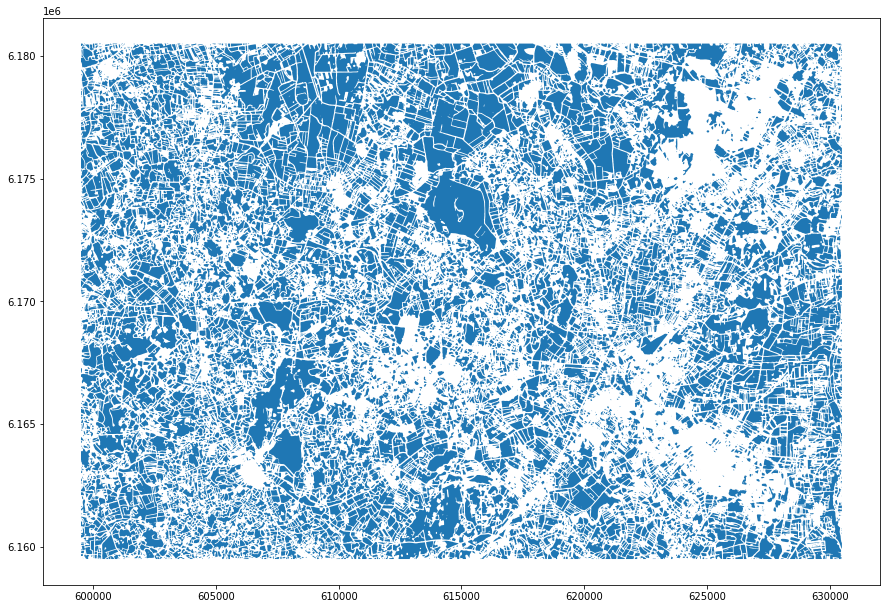

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))
vectors.plot(ax=ax)

# Merge UTM zones

 <div class="alert alert-block alert-info"><b>This step is only needed if the AOI spans multiple UTM zones</b> 

The procedure outline is:
* define geometries for two UTM zones and their overlap
* load the two single-UTM-zone vector predictions
* split them into parts: non-overlapping (completely within UTM zone) and overlapping
* merge the overlaps by:
  * transform them to single CRS (WGS84)
  * spatial join of the overlapping geodataframes from the two zones
  * finding geometries that do not overlap (and keeping them)
  * unary_union-ize the polygons that intersect and merge them to the geometries from previous step
* transform everything to resulting (common) CRS
* clean up the results (remove geometries with area larger than X * max allowed size of polygon)
* simplify geometries


In [27]:
utm_merging_config = {
    "bucket_name": BUCKET_NAME, 
    "aws_access_key_id": AWS_ACCESS_KEY_ID,
    "aws_secret_access_key": AWS_SECRET_ACCESS_KEY,
    "aws_region": AWS_REGION,
    "grid_definition_file": GRID_PATH,
    "time_intervals": ["MAY"],
    "utms": ["32634", "32635"],
    "contours_dir": os.path.join(PROJECT_DATA_ROOT, "fd-contours"), 
    "resulting_crs": "",  # !! Choose an appropriate meter-based CRS  that covers the AOI !! 
    "max_area": 4153834.1, 
    "simplify_tolerance": 2.5, 
    "n_workers": 16,
    "overlap_buffer": -0.0001,
    "zone_buffer": 0.00001
}

In [ ]:
merge_zones(utm_merging_config)